In [1]:
%matplotlib inline

In [2]:
import numpy as np
from IPython.display import Image
from fatiando.vis import mpl, myv
from fatiando.gravmag import prism, sphere
from fatiando.utils import contaminate

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
import functions as f

### Load data from txt files

These data are the output of the application to real data.

In [5]:
files = ['..\\data\\data0.txt', 
         '..\\data\\data1.txt',
         '..\\data\\data2.txt',
         '..\\data\\data3.txt']

nfiles = len(files)

In [6]:
data = []

for i in range(nfiles):
    data.append(np.loadtxt(files[i]))

In [7]:
mag_true = np.loadtxt('..\\data\\estimate_real.txt')

In [8]:
mag_true

array([[  129.92212,    17.37365,    40.1439 ],
       [  672.23611,    26.62932,   169.86928],
       [  989.74406,    30.24831,   170.66381],
       [  995.30656,    24.85233,   168.0694 ],
       [  564.86695,    62.97999,   127.54028],
       [ 1349.6365 ,    56.34603,     9.2497 ],
       [ 1097.40121,    44.19063,    13.07606],
       [ 1151.47208,    54.95238,    14.6971 ],
       [  355.92525,   -13.03439,     5.82444],
       [ 1283.29386,   -76.24577,    -5.77769],
       [ 1130.91748,   -75.23991,    -3.94763],
       [ 1315.05326,   -74.31212,    -7.40493],
       [  287.10237,    62.6633 ,    39.5504 ],
       [ 1232.04768,    85.53766,    76.94846],
       [ 1243.42849,    84.54094,    43.78796],
       [ 1126.42339,    83.85193,   159.84944]])

Here, the estimated magnetization obtained with real data is modified in order to simulate an observed data set. Only the estimated inclination and declination are modified.

In [9]:
mean_inc0 = np.mean(mag_true[1:4,1])
mean_inc1 = np.mean(mag_true[5:8,1])
mean_inc2 = np.mean(mag_true[9:12,1])
mean_inc3 = np.mean(mag_true[13:16,1])

mean_dec0 = np.mean(mag_true[1:4,2])
mean_dec1 = np.mean(mag_true[5:8,2])
mean_dec2 = np.mean(mag_true[9:12,2])
mean_dec3 = np.mean(mag_true[13:16,2])

In [10]:
mag_true[0:4,1] = mean_inc0
mag_true[4:8,1] = mean_inc1
mag_true[8:12,1] = mean_inc2
mag_true[12:16,1] = mean_inc3

In [11]:
mag_true[0:4,2] = mean_dec0
mag_true[4:8,2] = mean_dec1
mag_true[8:12,2] = mean_dec2
mag_true[12:16,2] = mean_dec3

In [12]:
mag_true

array([[  129.92212   ,    27.24332   ,   169.53416333],
       [  672.23611   ,    27.24332   ,   169.53416333],
       [  989.74406   ,    27.24332   ,   169.53416333],
       [  995.30656   ,    27.24332   ,   169.53416333],
       [  564.86695   ,    51.82968   ,    12.34095333],
       [ 1349.6365    ,    51.82968   ,    12.34095333],
       [ 1097.40121   ,    51.82968   ,    12.34095333],
       [ 1151.47208   ,    51.82968   ,    12.34095333],
       [  355.92525   ,   -75.26593333,    -5.71008333],
       [ 1283.29386   ,   -75.26593333,    -5.71008333],
       [ 1130.91748   ,   -75.26593333,    -5.71008333],
       [ 1315.05326   ,   -75.26593333,    -5.71008333],
       [  287.10237   ,    84.64351   ,    93.52862   ],
       [ 1232.04768   ,    84.64351   ,    93.52862   ],
       [ 1243.42849   ,    84.64351   ,    93.52862   ],
       [ 1126.42339   ,    84.64351   ,    93.52862   ]])

### Parameters of the sample

In [13]:
N = 16 # number of prisms forming the sample
M = 3*N # number of parameters to be estimated

Lx = 0.001 # in m
Ly = 0.003 # in m
Lz = Ly  # in m

shape = (42,102) # (Ny, Nx)

In [14]:
xmin_sample = -0.5*Lx*N #in m
centers = [100.*(xmin_sample + 0.5*Lx + i*Lx) for i in range(N)] #in cm

### Synthetic Sample

In [15]:
sample = f.sample(Lx,Ly,Lz,N, m = mag_true[:,0], inc = mag_true[:,1], dec = mag_true[:,2])

### Synthetic data

The cell below introduces 

In [16]:
# Simulate a Gaussian noise with null mean
stdev_data = 30000.0 # nT

# Simulate constant bias added to the observed data on each plane
#b0 = -26000. # uT
#b1 = -10000. # uT
#b2 = -26000. # uT
#b3 = -13000. # uT

b0 = 0. # uT
b1 = 0. # uT
b2 = 0. # uT
b3 = 0. # uT

# Simulate sensor-to-sample errors
#dh0 = (10.**-6)*(80.) # m
#dh1 = (10.**-6)*(-170.) # m
#dh2 = (10.**-6)*(-100.) # m
#dh3 = (10.**-6)*(270.) # m

dh0 = 0. # m
dh1 = 0. # m
dh2 = 0. # m
dh3 = 0. # m

In [17]:
B_obs = [contaminate(prism.bz(data[0][:,0], data[0][:,1], data[0][:,2] + dh0, sample), stddev = stdev_data) + b0,
         contaminate(prism.by(data[1][:,0], data[1][:,1] + dh1, data[1][:,2], sample), stddev = stdev_data) + b1,
         contaminate(prism.bz(data[2][:,0], data[2][:,1], data[2][:,2] + dh2, sample), stddev = stdev_data) + b2,
         contaminate(prism.by(data[3][:,0], data[3][:,1] + dh3, data[3][:,2], sample), stddev = stdev_data) + b3]

### Interpretation model

In [18]:
model = f.sample(Lx,Ly,Lz,N)

In [19]:
xmin = np.min([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
xmax = np.max([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
ymin = np.min([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
ymax = np.max([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
zmin = np.min([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])
zmax = np.max([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])

volume = [xmin, xmax, ymin, ymax, zmin, zmax]

In [20]:
scene = myv.figure()
myv.prisms(model, color= (0.4,0.4,0.4))

myv.points(np.vstack((data[0][:,0], data[0][:,1], data[0][:,2])).T, 
           color=(1, 0, 0), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[1][:,0], data[1][:,1], data[1][:,2])).T, 
           color=(0, 0, 1), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[2][:,0], data[2][:,1], data[2][:,2])).T, 
           color=(0, 1, 0), size=0.00005, opacity=1, spherical=False)
myv.points(np.vstack((data[3][:,0], data[3][:,1], data[3][:,2])).T, 
           color=(0, 0, 0), size=0.00005, opacity=1, spherical=False)



ax = myv.axes(myv.outline(volume), ranges=[b for b in volume], nlabels=5, fmt='%.3f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (cm)', 'y (cm)', 'z (cm)'
ax.axes.font_factor = 1.2
myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.savefig('model.png')
myv.show()
#Image(filename='model.png')

### Inversion

In [21]:
A = []
for i in range(4):
    A.append(f.sensitivity(N, data[i][:,0], data[i][:,1], data[i][:,2], model,i))

In [22]:
R = np.zeros(M+1)
R[0] = 1.
R[3] = -1.
R = np.resize(R, (M-3,M))

In [23]:
u0 = 0.

In [24]:
H = np.dot(np.vstack(A).T, np.vstack(A))

In [25]:
f0 = np.trace(H)/M
f0

12526138.706979195

In [26]:
H = H + u0*f0*np.dot(R.T, R)

In [27]:
h = np.dot(np.vstack(A).T, np.hstack(B_obs))

In [28]:
p_est = np.linalg.solve(H, h)

In [29]:
#p_est = f.L2_norm(np.vstack(A),np.hstack(B_obs))
#p_est = f.L2_norm(np.vstack((A[1],A[2],A[3])),np.hstack((B_obs[1],B_obs[2], B_obs[3])))
#p_est = f.L2_norm(np.vstack((A[0],A[1],A[2])),np.hstack((B_obs[0],B_obs[1], B_obs[2])))
#p_est = f.L2_norm(np.vstack((A[1],A[2])),np.hstack((B_obs[1],B_obs[2])))
#p_est = f.L2_norm(np.array(A[1]),np.array(B_obs[1]))
#p_est = f.L2_norm(np.array(A[0]),np.array(B_obs[0]))

In [30]:
mag_r = f.parameters_sph(N,p_est)

In [31]:
B_pre = []
for i in range(4):
    B_pre.append(np.dot(A[i],p_est))

In [32]:
r_norm = []
r_mean = []
r_std = []

for i in range(4):
    aux1,aux2,aux3 = f.residual(0.001*B_obs[i],0.001*B_pre[i])
    r_norm.append(aux1) # in uT
    r_mean.append(aux2) # in uT
    r_std.append(aux3)  # in uT

### Plotting of the observed and predicted data 

C:\Users\Andre_Projeto\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


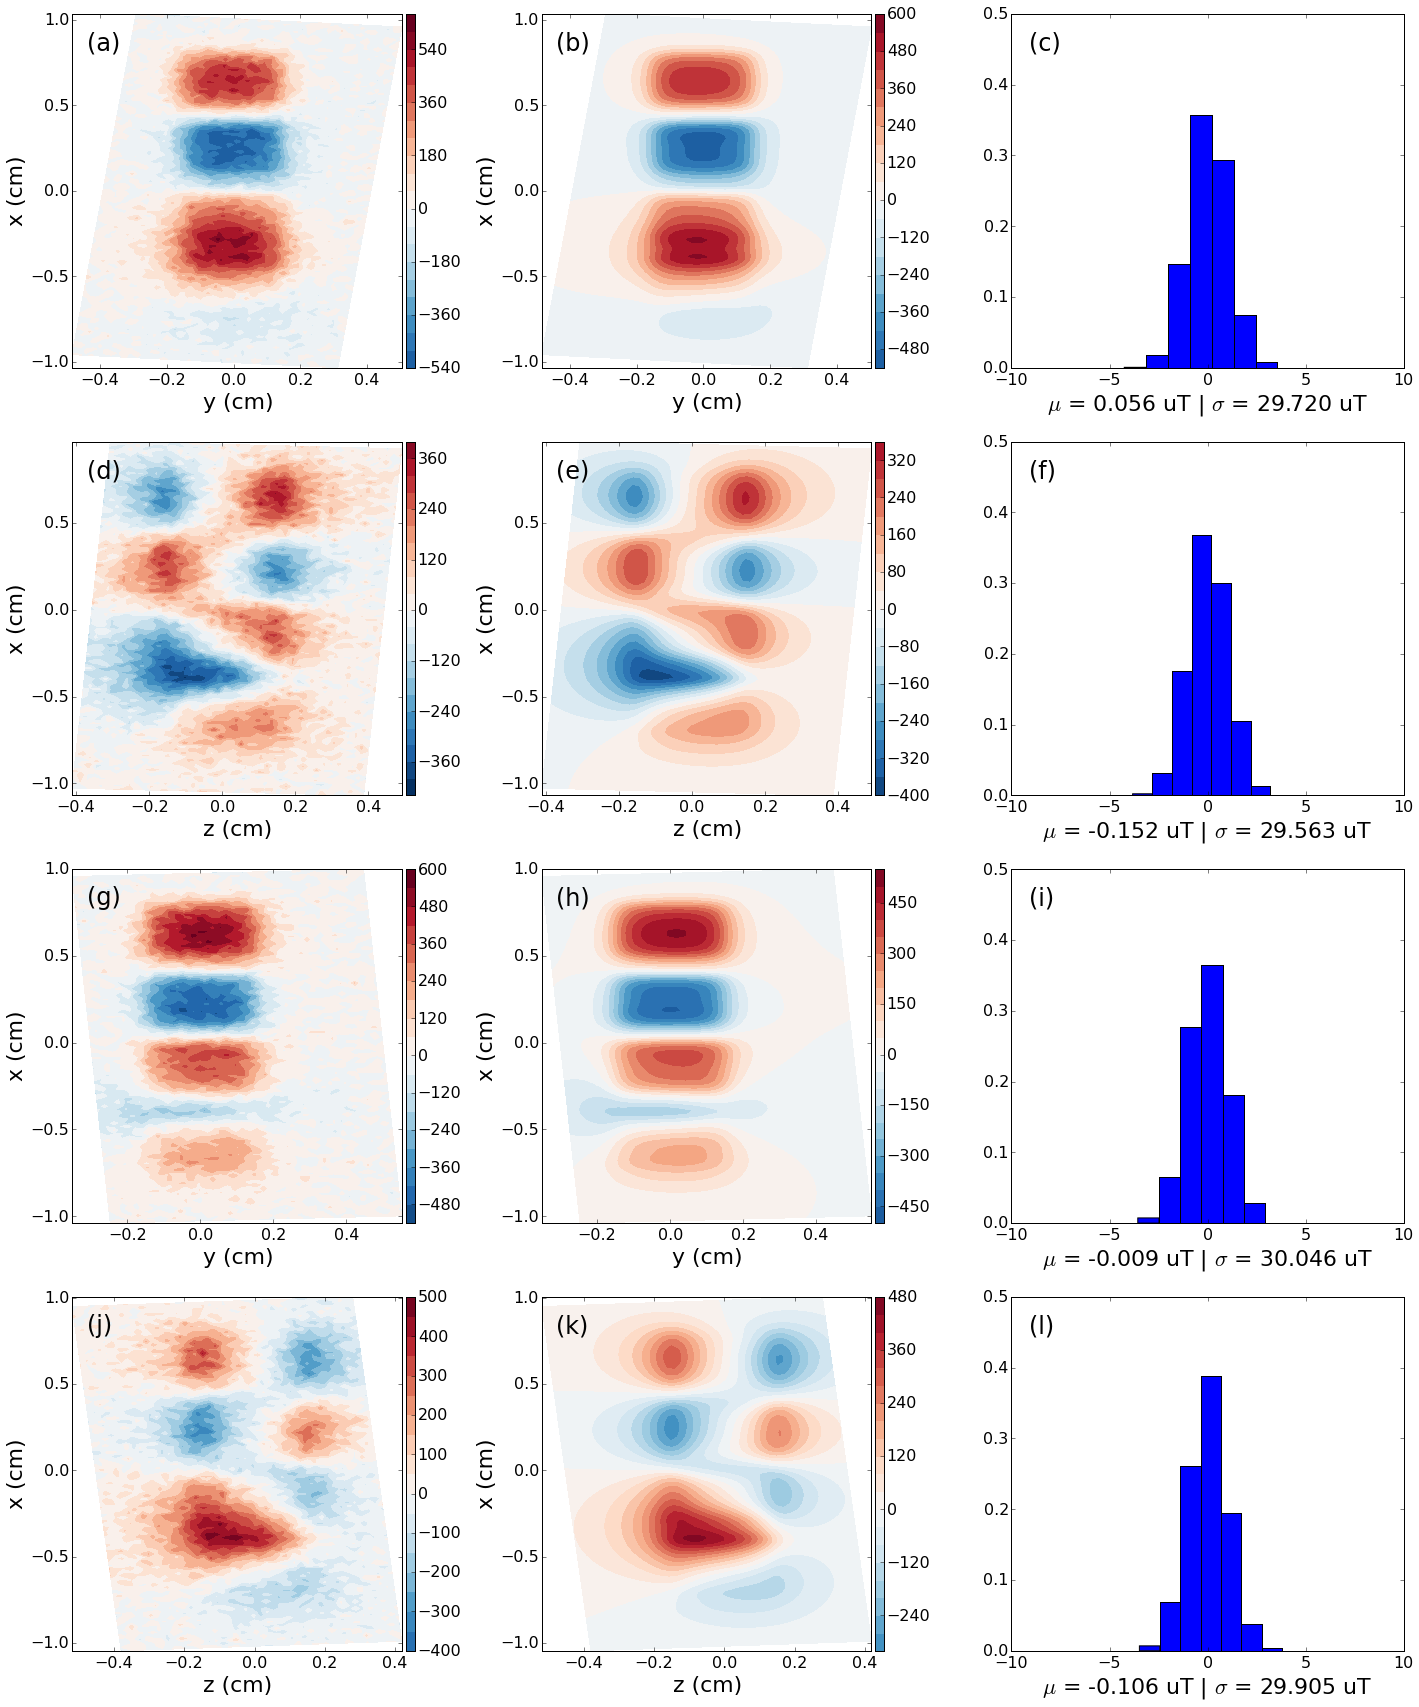

In [33]:
title_font = 22
bottom_font = 16

labels = ['(a)', '(b)', '(c)', 
          '(d)', '(e)', '(f)',
          '(g)', '(h)', '(i)',
          '(j)', '(k)', '(l)']

lables_place = (0.05, 0.90)
lables_size = 24

mpl.close('all')
mpl.figure(figsize=(20,24), tight_layout=True)

for i in range(0,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i + 1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i + 2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
    
for i in range(1,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i+1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i+2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('..\\manuscript\\Figs\\Fig5_HQ.eps')
mpl.savefig('..\\manuscript\\Figs\\Fig5_LQ.png')

mpl.show()

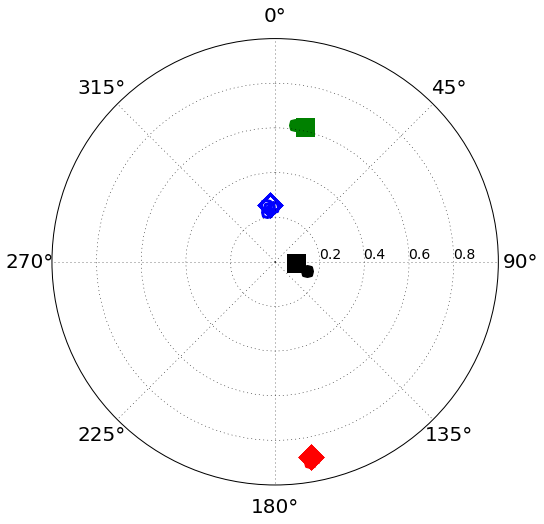

In [34]:
mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8], angle=90.)

f.proj_polar(4,mag_true[:4,:],color='r',simbolo='D',size=16)
f.proj_polar(4,mag_true[4:8,:],color='g',simbolo='s',size=16)
f.proj_polar(4,mag_true[8:12,:],color='b',simbolo='D',size=16)
f.proj_polar(4,mag_true[12:16,:],color='k',simbolo='s',size=16)

f.proj_polar(4,mag_r[:4,:],color='r',size=10)
f.proj_polar(4,mag_r[4:8,:],color='g',size=10)
f.proj_polar(4,mag_r[8:12,:],color='b',size=10)
f.proj_polar(4,mag_r[12:16,:],color='k',size=10)

mpl.xticks(fontsize=20) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.0)
#mpl.savefig('estimate_polar_simul_validation.png')
mpl.show() 

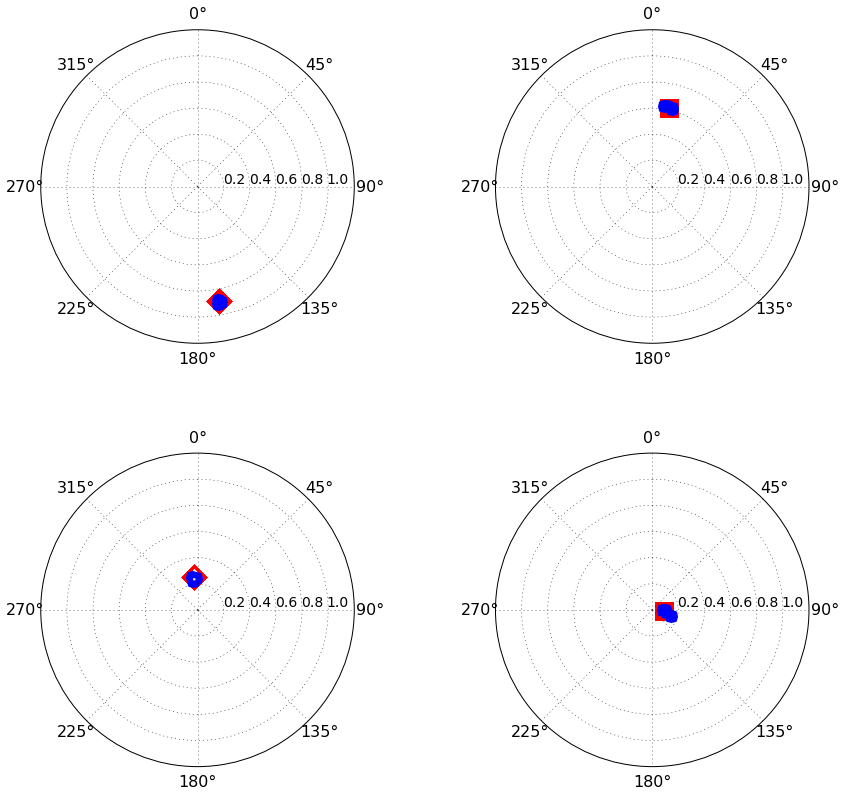

In [35]:
mpl.figure(figsize=(12,12))

ax = mpl.subplot(221, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)
f.proj_polar(4,mag_true[:4,:],color='r',simbolo='D',size=16)
f.proj_polar(4,mag_r[:4,:],color='b',size=10)

mpl.xticks(fontsize=16) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.2)

ax = mpl.subplot(222, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)

f.proj_polar(4,mag_true[4:8,:],color='r',simbolo='s',size=16)
f.proj_polar(4,mag_r[4:8,:],color='b',size=10)

mpl.xticks(fontsize=16) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.2)

ax = mpl.subplot(223, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)

f.proj_polar(4,mag_true[8:12,:],color='r',simbolo='D',size=16)
f.proj_polar(4,mag_r[8:12,:],color='b',size=10)

mpl.xticks(fontsize=16) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.2)

ax = mpl.subplot(224, polar=True)
ax.set_theta_direction(-1) 
ax.set_theta_zero_location('N') 
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)

f.proj_polar(4,mag_true[12:16,:],color='r',simbolo='s',size=16)
f.proj_polar(4,mag_r[12:16,:],color='b',size=10)

mpl.xticks(fontsize=16) 
mpl.yticks(fontsize=14) 
mpl.ylim(0.0, 1.2)

mpl.tight_layout(w_pad=5.)

#mpl.savefig('estimate_polar_simul.png')

mpl.show() 

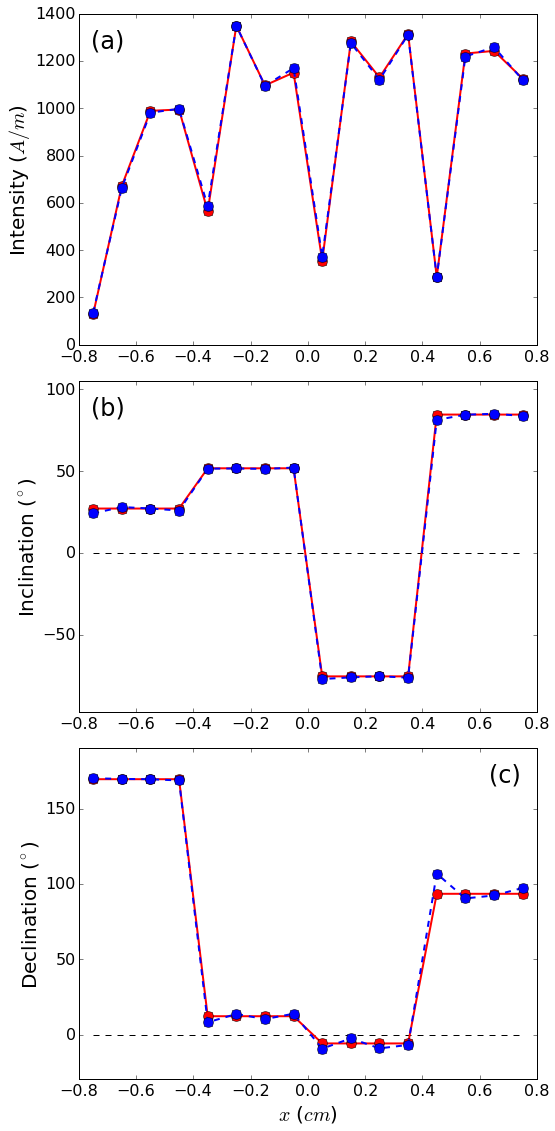

In [36]:
label_font = 20
legend_font = 16

labels = ['(a)', '(b)', '(c)']

lables_place = (0.03, 0.90)
lables_size = 24

mpl.show()
mpl.close('all')
mpl.figure(figsize=(8, 16), tight_layout=True)

mpl.subplot(3,1,1)
#mpl.plot([np.min(centers), np.max(centers)], [1200.0, 1200.0], 'k--',
#         label='Saturation magnetization')
mpl.plot(centers, mag_true[:,0], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,0], 'ro', markersize=10, label='True')
mpl.plot(centers, mag_r[:,0], 'b--', linewidth=2)
mpl.plot(centers, mag_r[:,0], 'bo', markersize=10,label='Estimated')
mpl.ylabel('Intensity ($A/m$)', fontsize=label_font)
mpl.ylim(0., np.max(mag_r[:,0]) + 50.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[0], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.subplot(3,1,2)
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [45.0, 45.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [90.0, 90.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [-90.0, -90.0], 'k--')
mpl.plot(centers, mag_true[:,1], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,1], 'ro', markersize=10, label='True')
mpl.plot(centers, mag_r[:,1], 'b--', linewidth=2)
mpl.plot(centers, mag_r[:,1], 'bo', markersize=10, label='Estimated')
mpl.ylabel('Inclination ($^{\circ}$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,1]) - 20., np.max(mag_r[:,1]) + 20.)
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.subplot(3,1,3)
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
#mpl.plot([np.min(centers), np.max(centers)], [180.0, 180.0], 'k--')
mpl.plot(centers, mag_true[:,2], 'r-', linewidth=2)
mpl.plot(centers, mag_true[:,2], 'ro', markersize=10, label='True')
mpl.plot(centers, mag_r[:,2], 'b--', linewidth=2)
mpl.plot(centers, mag_r[:,2], 'bo', markersize=10, label='Estimated')
mpl.ylabel('Declination ($^{\circ}$)', fontsize=label_font)
#mpl.xlabel('Sample length ($cm$)', fontsize=label_font)
mpl.xlabel('$x$ ($cm$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,2]) - 20., np.max(mag_r[:,2]) + 20.)
#mpl.savefig('estimate_int_inc_dec_simul_validation.eps')
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[2], xy = (0.90, 0.90), 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('..\\manuscript\\Figs\\Fig6_HQ.eps')
mpl.savefig('..\\manuscript\\Figs\\Fig6_LQ.png')

mpl.show()